In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pynwb import NWBFile, NWBHDF5IO
from scipy import signal

Define useful functions

In [2]:
def subsample_lfp(lfp_raw, selected_channels, subsampling_factor):
    """
    Subsamples LFP data

    Parameters:
    ----------

    lfp_raw : numpy.ndarray
        2D array of LFP values (time x channels)
    selected_channels : numpy.ndarray
        Indices of channels to select (spatial subsampling)
    downsampling_factor : int
        Factor by which to subsample in time

    Returns:

    lfp_subsampled : numpy.ndarray
        New 2D array of LFP values

    """

    num_samples = len(lfp_raw[::subsampling_factor, 0])
    num_channels = selected_channels.size
    lfp_subsampled = np.zeros((num_samples, num_channels), dtype='int16')

    for new_ch, old_ch in enumerate(selected_channels):
        tmp = signal.decimate(
            lfp_raw[:, old_ch], subsampling_factor, ftype='iir', zero_phase=True
        )
        assert (len(tmp) == num_samples)
        lfp_subsampled[:, new_ch] = tmp.astype('int16')

    return lfp_subsampled

Set path to downloaded NWB files

In [3]:
NWBfiles_dir = Path(r"G:\TempletonNWB\testdata")

Get a dataframe of some session metadata

In [4]:
subject_session_list = []
for filei in NWBfiles_dir.iterdir():
    if 'nwb' in str(filei):
        print(filei)
        io = NWBHDF5IO(filei, mode="r")
        try:
            nwbfile = io.read()
            if 'ketanserin' in nwbfile.pharmacology:
                session_drug = 'ketanserin'
            elif 'psilocybin' in nwbfile.pharmacology:
                session_drug = 'psilocybin'
            elif 'saline' in nwbfile.pharmacology:
                session_drug = 'saline'
            elif 'isoflurane' in nwbfile.pharmacology:
                session_drug = 'isoflurane'
            elif 'urethane' in nwbfile.pharmacology:
                session_drug = 'urethane'
            subject_session_list.append([
                nwbfile.subject.subject_id, nwbfile.session_id, nwbfile.subject.sex, filei, session_drug,
                np.any([True if 'EEG' in x else False for x in nwbfile.electrode_groups.keys()]),
                np.any([True if 'probe' in x else False for x in nwbfile.electrode_groups.keys()]),
            ])
            io.close
        except TypeError:
            print(' Missing version in file??')
subject_df = pd.DataFrame(subject_session_list, columns=['subject', 'session_id', 'sex', 'file_loc', 'drug', 'has_EEG', 'has_NPX'])

G:\TempletonNWB\testdata\673449-20230419-test01pynwb31.nwb
G:\TempletonNWB\testdata\676726-20230503-test01pynwb31.nwb
G:\TempletonNWB\testdata\676726-20230504-test01pynwb31.nwb
G:\TempletonNWB\testdata\676727-20230510-test01pynwb31.nwb
G:\TempletonNWB\testdata\676727-20230511-test01pynwb31.nwb
G:\TempletonNWB\testdata\676727-20230512-test01pynwb31.nwb


In [5]:
subject_df.tail()

,subject,session_id,sex,file_loc,drug,has_EEG,has_NPX
1,676726,20230503,M,G:\TempletonNWB\testdata\676726-20230503-test0...,psilocybin,True,True
2,676726,20230504,M,G:\TempletonNWB\testdata\676726-20230504-test0...,isoflurane,True,True
3,676727,20230510,F,G:\TempletonNWB\testdata\676727-20230510-test0...,psilocybin,True,True
4,676727,20230511,F,G:\TempletonNWB\testdata\676727-20230511-test0...,isoflurane,True,True
5,676727,20230512,F,G:\TempletonNWB\testdata\676727-20230512-test0...,urethane,True,True


# Load a single file to explore the data contained

In [6]:
subjectind = 5
io = NWBHDF5IO(subject_df.iloc[subjectind].file_loc, mode="r")
nwbfile = io.read()

Examine the NWB file

In [7]:
nwbfile

Data type,int16
Shape,"(11572480, 30)"
Array size,662.18 MiB
Chunk shape,"(45205, 1)"
Compression,gzip
Compression opts,4
Compression ratio,1.3199599666770698
Data type,float64
Shape,"(11572480,)"
Array size,88.29 MiB
Chunk shape,"(11302,)"


## Show the subject and session info

In [8]:
nwbfile.subject

subject pynwb.file.Subject at 0x2135422548528
Fields:
  age: P80D
  age__reference: birth
  description: mouse676727
  sex: F
  species: Mus musculus
  strain:  C57BL/6J 
  subject_id: 676727

What happened during this session?

In [9]:
print('This session was a {}.\n\tThe drugs delivered were: {}.\n\tThe stimuli were: {}.'.format(
    nwbfile.session_description, nwbfile.pharmacology, nwbfile.stimulus_notes))

This session was a urethane experiment with EEG and Neuropixels (electrical and visual).
	The drugs delivered were: urethane (initial dose given before recording 1.5 g/kg, i.v.).
	The stimuli were: single pulse electrical stimuli delivered to MOs6a, CCF coordinates [111, 108, 178]; visual stimuli (white circles) presented on monitor in front of right eye.


## Explore the data

### Stimulus information
<br>Include more information about stimuli delivered.
<br>If external stimuli were delivered in this session, make a DataFrame from the trial table.

In [10]:
trials_df = nwbfile.trials.to_dataframe()
trials_df.head()

,start_time,stop_time,stimulus_type,stimulus_description,estim_current,image_id,behavioral_epoch
id,,,,,,,
0,431.64557,431.64597,electrical,biphasic_pulse,40,-1,urethane
1,438.25267,438.25307,electrical,biphasic_pulse,40,-1,urethane
2,445.71502,445.71542,electrical,biphasic_pulse,40,-1,urethane
3,452.22010,452.22050,electrical,biphasic_pulse,40,-1,urethane
4,459.49547,459.49587,electrical,biphasic_pulse,40,-1,urethane


In [11]:
stimuli_presented = np.unique(trials_df.stimulus_description.values)
print(stimuli_presented)

['biphasic_pulse' 'white_circle']


#### Natural images ####
<br>In some sessions natural images were displayed. The Natural Images stimulus consisted of a subset of 118 natural images taken from the Berkeley Segmentation Dataset, the van Hateren Natural Image Dataset, and the McGill Calibrated Colour Image Database. The images were presented in greyscale and were contrast-normalized and resized to 1,174 × 918 pixels. The images were presented in a random order for a variable duration (100-1000 ms), with an intervening grey period.
<br><br>If natural scenes were delivered as the visual stimuli, show some images.

In [12]:
if 'natural_scene' in stimuli_presented:
    natural_scene_images = nwbfile.stimulus['natural_scenes']
    natscene_df = trials_df[trials_df['stimulus_description'] == 'natural_scene']
    images_presented = natscene_df.image_id.values[:4]

    fig, axs = plt.subplots(2, 2, figsize=(10,6), constrained_layout=True)
    for ax, image_id in zip(axs.flatten(), images_presented):
        ax.imshow(natural_scene_images.images[str(image_id)], aspect="equal", cmap="gray")
        ax.set_title('Natural scene {:d}'.format(image_id))

else:
    print('Natural scenes were not part of this session.')

Natural scenes were not part of this session.


### Running speed
<br>During the experimental session, the mouse was head-fixed on top of a rotating disc, free to rest, walk, or run. Rotation of the disc was tracked using a digital rotary encoder. The angular velocity of the disc was calculated by binning the digital edges into 10 ms windows (a sample rate of 100 Hz). Then the angular velocity of the disc was used to calculate the linear velocity of the mouse.

In [13]:
speed = nwbfile.processing["behavior"]["BehavioralTimeSeries"]["running_speed"].data[:]
speedts = (np.arange(len(speed)) / nwbfile.processing["behavior"]["BehavioralTimeSeries"]["running_speed"].rate) + nwbfile.processing["behavior"]["BehavioralTimeSeries"]["running_speed"].starting_time

smooth_speed = np.zeros_like(speed)
k = 10 # filter window is actually k*2+1
for i in range(k, len(speed)-k-1):
    smooth_speed[i] = np.mean(speed[i-k:i+k]) # each point is the average of k surrounding points
smooth_speed[:k] = speed[:k]
smooth_speed[-k-1:] = speed[-k-1:]

Text(0.5, 1.0, "Subject's speed across the whole session")

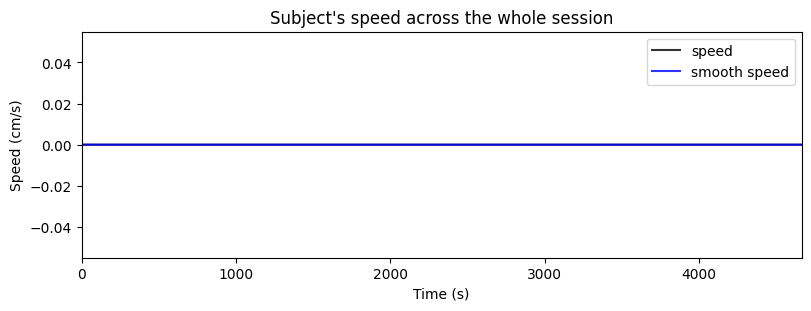

In [14]:
fig, ax = plt.subplots(figsize=(8,3), constrained_layout=True)
ax.plot(speedts, speed, color='k', alpha=0.8, label='speed')
ax.plot(speedts, smooth_speed, color='b', alpha=0.8, label='smooth speed')
ax.legend(loc='upper right')
ax.set_xlim(speedts[0], speedts[-1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Speed ({})'.format(nwbfile.processing["behavior"]["BehavioralTimeSeries"]["running_speed"].unit))
ax.set_title("Subject's speed across the whole session")

### Pupil size
<br>During the experimental session, a camera recorded a video (30 Hz frame rate) of the mouse’s right eye. To extract the pupil and eye metrics from the video, 12 points around the pupil and 4 points around the eye were manually annotated for 150 frames. The manual annotations were then used to train a network (ResNet-50, DeepLabCut version 2.3.5) using 500,000 iterations; each session had its own trained network. The trained network was used to predict 12 pupil and 4 eye points for every frame and each point was given a confidence score. Labeled pupil points with a confidence score greater than 0.9 were considered for further analysis, all other points were dropped. If a frame had at least 6 labeled pupil points (high confidence) an ellipse was fit to the pupil and the largest radius was extracted as the pupil size. If a frame had less than 6 high confidence points, all pupil metrics for that frame were labeled with not-a-number (NaN). The pupil and eye metrics tracked were:
<br>
<br>**pupil_center_x**: the x position of the center of the ellipse fit to the annotated pupil points (pixels)
<br>**pupil_center_y**: the y position of the center of the ellipse fit to the annotated pupil points (pixels)
<br>**pupil_width**: the semimajor (horizontal radius) axis of the pupil ellipse (pixels)
<br>**pupil_height**: the semiminor (vertical radius) axis of the pupil ellipse (pixels)
<br>**pupil_phi**: the tilt (angle the semimajor axis makes with the x-axis) of the pupil ellipse (radians)
<br>**eye_width**: the distance between the corners of the eye (pixels)
<br>
<br>Some sessions do not include pupil tracking due to poor video quality.

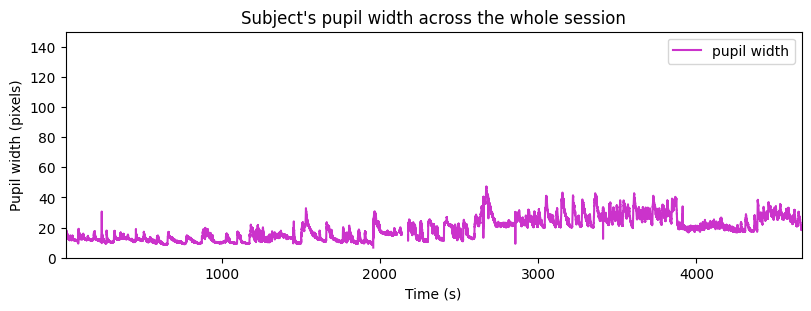

In [15]:
try:
    pupil_width = nwbfile.processing["behavior"]["PupilTracking"]["pupil_width"].data[:]
    pupil_timestamps = nwbfile.processing["behavior"]["PupilTracking"]["pupil_width"].timestamps[:]

    fig, ax = plt.subplots(figsize=(8,3), constrained_layout=True)
    ax.plot(pupil_timestamps, pupil_width, color='m', alpha=0.8, label='pupil width')
    ax.legend()
    ax.set_xlim(pupil_timestamps[0], pupil_timestamps[-1])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pupil width ({})'.format(nwbfile.processing["behavior"]["PupilTracking"]["pupil_width"].unit))
    ax.set_title("Subject's pupil width across the whole session")
    ax.set_ylim([0, 150])
except:
    print('This session does not have pupil tracking.')

### Drug information

In [16]:
print('Drug(s) delivered during this session: {}.'.format(nwbfile.pharmacology))

Drug(s) delivered during this session: urethane (initial dose given before recording 1.5 g/kg, i.v.).


In [17]:
if ('ketanserin' in nwbfile.pharmacology) or ('psilocybin' in nwbfile.pharmacology) or ('saline' in nwbfile.pharmacology):
    print('There were two i.p. injections performed during this session roughly 10-15 minutes apart. ')
    injection_epochs = nwbfile.epochs.to_dataframe()
    print(injection_epochs)
elif 'isoflurane' in nwbfile.pharmacology:
    print('Get the isoflurane level signal.')
    isoflurane_level = nwbfile.acquisition["isoflurane_level"].data[:]
    isoflurane_timestamps = (np.arange(0, len(isoflurane_level)) / nwbfile.acquisition["isoflurane_level"].rate) + nwbfile.acquisition["isoflurane_level"].starting_time
    fig, ax = plt.subplots(figsize=(8,3), constrained_layout=True)
    ax.plot(isoflurane_timestamps, isoflurane_level, color='g', alpha=0.8, label='isoflurane level')
    ax.legend()
    ax.set_xlim(isoflurane_timestamps[0], isoflurane_timestamps[-1])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Isoflurane level ({})'.format(nwbfile.acquisition["isoflurane_level"].unit))
    ax.set_title("Isoflurane level across the whole session")
    ax.set_ylim([-0.1, 5.1])
elif 'urethane' in nwbfile.pharmacology:
    print('An anesthetic dose of {} was delivered prior to beginning the experiment.'.format(nwbfile.pharmacology))
    try:
        urethane_boost_epoch = nwbfile.epochs.to_dataframe()
        print('A boost injection of urethane was delivered during the experiment.')
        print(urethane_boost_epoch)
    except:
        print('No boost injection was delivered during this session.')

An anesthetic dose of urethane (initial dose given before recording 1.5 g/kg, i.v.) was delivered prior to beginning the experiment.
No boost injection was delivered during this session.


### EEG data

In [18]:
if 'EEG' in nwbfile.session_description:
    EEG_data = nwbfile.acquisition['ElectricalSeriesEEG'].data[:] * nwbfile.acquisition['ElectricalSeriesEEG'].conversion * 1E6
    EEG_timestamps = nwbfile.acquisition['ElectricalSeriesEEG'].timestamps[:]
    print(EEG_data.shape)
    EEG_electrodes = nwbfile.acquisition['ElectricalSeriesEEG'].electrodes.to_dataframe()
    print(EEG_electrodes.head())
else:
    print('There is no EEG data in this experiment.')

(11572480, 30)
   location                                              group  is_data_valid  \
id                                                                              
0      VISl  EEG array pynwb.ecephys.ElectrodeGroup at 0x21...           True   
1      VISp  EEG array pynwb.ecephys.ElectrodeGroup at 0x21...           True   
2    RSPagl  EEG array pynwb.ecephys.ElectrodeGroup at 0x21...           True   
3     VISal  EEG array pynwb.ecephys.ElectrodeGroup at 0x21...           True   
4      VISp  EEG array pynwb.ecephys.ElectrodeGroup at 0x21...           True   

    probe_vertical_position  probe_horizontal_position group_name      x  \
id                                                                         
0                        -1                         -1  EEG array  377.0   
1                        -1                         -1  EEG array  377.0   
2                        -1                         -1  EEG array  377.0   
3                        -1          

### Neuropixels probes data

In [19]:
if 'Neuropixels' in nwbfile.session_description:
    print('There were Neuropixels recordings in this experiment.')
else:
    print('There were not Neuropixels recordings in this experiment.')

There were Neuropixels recordings in this experiment.


#### Units

In [20]:
all_units_df = nwbfile.units.to_dataframe()
all_units_df.head()

,location,x,y,z,isi_violations,amplitude_cutoff,presence_ratio,waveform_duration,spike_times,electrodes,electrode_group,waveform_mean
id,,,,,,,,,,,,
0,VAL,267,175,183,0.000000,0.004242,0.99,0.480737,"[40.031980272418565, 53.29689075918084, 56.226...",location ...,probeB pynwb.ecephys.ElectrodeGroup at 0x21354...,"[0.0, -2.5271999999999984e-07, -8.706750000000..."
1,VAL,267,174,183,0.422575,0.006693,0.99,0.439531,"[53.3758906231169, 53.381590613299636, 70.3502...",location ...,probeB pynwb.ecephys.ElectrodeGroup at 0x21354...,"[0.0, 7.066800000000035e-07, 8.919300000000039..."
2,VAL,267,175,183,1.314101,0.500000,0.99,0.467002,"[40.03598026552925, 42.82684212540707, 52.8801...",location ...,probeB pynwb.ecephys.ElectrodeGroup at 0x21354...,"[0.0, 6.702150000000008e-07, 1.213095000000000..."
3,VAL,267,175,183,0.155665,0.030705,0.99,0.384590,"[29.22479888596576, 29.661731466756414, 29.706...",location ...,probeB pynwb.ecephys.ElectrodeGroup at 0x21354...,"[0.0, -1.1419199999999989e-06, -1.326779999999..."
4,VAL,267,175,183,0.000000,0.000260,0.99,0.467002,"[35.31092173697897, 37.22468510751101, 39.3680...",location ...,probeB pynwb.ecephys.ElectrodeGroup at 0x21354...,"[0.0, 1.1622000000000109e-07, -3.2603999999999..."


#### LFP

In [21]:
list_of_NPXprobes = [x for x in nwbfile.electrode_groups.keys() if 'probe' in x]
print(list_of_NPXprobes)

['probeB', 'probeC', 'probeD', 'probeF']


In [36]:
testprobe = 'probeF'
# nwbfile.acquisition['LFP'+testprobe]['ElectricalSeries'+testprobe].data.shape
nwbfile.acquisition['LFP']['ElectricalSeries'+testprobe].data.shape
LFP_timestamps = nwbfile.acquisition['LFP']['ElectricalSeries'+testprobe].timestamps[:]

(11572321, 384)

In [37]:
probe_electrodes = nwbfile.acquisition['LFP']['ElectricalSeries'+testprobe].electrodes.to_dataframe()
probe_ch_areas = probe_electrodes.location.values
probe_electrodes.head()

,location,group,is_data_valid,probe_vertical_position,probe_horizontal_position,group_name,x,y,z,reference
id,,,,,,,,,,
1182,AON,probeF pynwb.ecephys.ElectrodeGroup at 0x21354...,True,20,43,probeF,114.0,226.0,255.0,"stainless steel skull screw, left CB"
1183,AON,probeF pynwb.ecephys.ElectrodeGroup at 0x21354...,True,20,11,probeF,114.0,226.0,255.0,"stainless steel skull screw, left CB"
1184,AON,probeF pynwb.ecephys.ElectrodeGroup at 0x21354...,True,40,59,probeF,113.0,225.0,254.0,"stainless steel skull screw, left CB"
1185,AON,probeF pynwb.ecephys.ElectrodeGroup at 0x21354...,True,40,27,probeF,113.0,225.0,254.0,"stainless steel skull screw, left CB"
1186,AON,probeF pynwb.ecephys.ElectrodeGroup at 0x21354...,True,60,43,probeF,113.0,225.0,254.0,"stainless steel skull screw, left CB"


In [38]:
print('This probe was referenced to the {}.'.format(probe_electrodes.reference.iloc[0]))

This probe was referenced to the stainless steel skull screw, left CB.


In [40]:
LFP_sample_rate = 1 / np.mean(np.diff(LFP_timestamps))
LFP_new_sample_rate = 500
downsample_factor = int(LFP_sample_rate / LFP_new_sample_rate)
## Design a bandpass filter ##
hardware_filter = signal.butter(1, Wn=[0.5, 100], btype='band', fs=LFP_new_sample_rate)

In [41]:
num_samples = len(nwbfile.acquisition['LFP']['ElectricalSeries'+testprobe].data[:, 0][::downsample_factor])
num_channels = nwbfile.acquisition['LFP']['ElectricalSeries'+testprobe].data.shape[1]
lfp_subsampled_filtered = np.zeros((num_samples, num_channels), dtype='float')
for chi in range(num_channels):
    lfp_chi_raw = nwbfile.acquisition['LFP']['ElectricalSeries'+testprobe].data[:, chi] * nwbfile.acquisition['LFP']['ElectricalSeries'+testprobe].conversion * 1E6
    lfp_subsampled = signal.decimate(lfp_chi_raw, downsample_factor, ftype='iir', zero_phase=True)
    lfp_subsampled_filtered[:, chi] = np.flip(signal.lfilter(*hardware_filter, np.flip(lfp_subsampled)))
LFP_new_timestamps = LFP_timestamps[::downsample_factor]

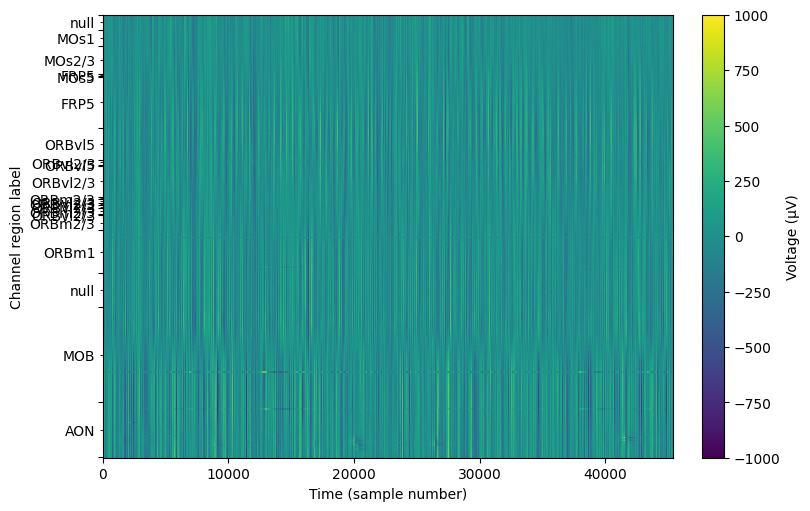

In [42]:
inds = LFP_new_timestamps < 120 # choose to load the first 120 s

fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
im = ax.imshow(lfp_subsampled_filtered[inds, :].T, aspect='auto', origin='lower', vmin=-1e3, vmax=1e3, interpolation='none')
ax.set_xlabel('Time (sample number)')
ax.set_ylabel('Channel region label')
cbar = fig.colorbar(im, label='Voltage (\u03bcV)')

## Set labels ##
bord = [0]
regi = probe_ch_areas[0]
labels = [regi]
for indb, regb in enumerate(probe_ch_areas[1:]):
    if regb == regi:
        continue
    else:
        bord.append(indb+1)
        labels.append(regb)
        regi = regb
bord.append(len(probe_ch_areas))
label_locs = bord[:-1] + np.diff(bord)/2
        
ax.set_yticks(bord)
ax.set_yticklabels('')

ax.set_yticks(label_locs, minor=True)
ax.set_yticklabels(labels, minor=True);

# Close the file

In [43]:
io.close()